In [1]:
# pip3 instacll opencv-python sklearn matplotlib scikit-learn scipy
# NOTE: if any error after installing with pip, use brew for Mac or conda for Windows
import json
import os
import cv2
from PIL import Image
import numpy as np
from tensorflow import keras
from keras import layers
from keras.models import model_from_json
from keras.applications import ResNet50, MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import load_model, Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
from keras import backend as K
import gc
import tensorflow as tf
from functools import partial
from sklearn import metrics
from collections import Counter
import itertools
%matplotlib inline

# Load Pre-trained Model and History

In [2]:
history=np.load('history.npy',allow_pickle='TRUE').item()
model = load_model('cancer_pretrained_model.h5')

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-13 17:56:24.868796: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-13 17:56:24.869327: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Prediction

In [3]:
print(os.getcwd())
model.load_weights("best_weights")

/Users/macbook/cancern-treatment


In [4]:
# restore , x_val, y_val, X_test, Y_test from model training in different .ipynb 
%store -r

In [5]:
Y_val_pred = model.predict(x_val)

2023-02-13 17:56:31.170590: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-13 17:56:31.475525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


38/38 [==============================] - 6s 132ms/step


In [6]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.8858333333333334

In [7]:
Y_pred = model.predict(X_test)

124/124 [==============================] - 16s 132ms/step


# Data Generator

In [8]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(
        zoom_range=2, 
        rotation_range = 90,
        horizontal_flip=True, 
        vertical_flip=True, 
    )

# Get Predictions from Model

In [9]:
from tqdm import tqdm

tta_steps = 5
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]2023-02-13 17:56:54.436356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


61/61 [==============================] - 22s 327ms/step


 20%|██        | 1/5 [00:22<01:31, 22.79s/it]

61/61 [==============================] - 20s 324ms/step


 40%|████      | 2/5 [00:45<01:07, 22.55s/it]

61/61 [==============================] - 21s 330ms/step


 60%|██████    | 3/5 [01:08<00:45, 22.79s/it]

61/61 [==============================] - 21s 339ms/step


 80%|████████  | 4/5 [01:31<00:23, 23.14s/it]

61/61 [==============================] - 21s 331ms/step


100%|██████████| 5/5 [01:54<00:00, 22.91s/it]


### Confusion Matrix

Confusion matrix, without normalization
[[1587  394]
 [ 148 1832]]


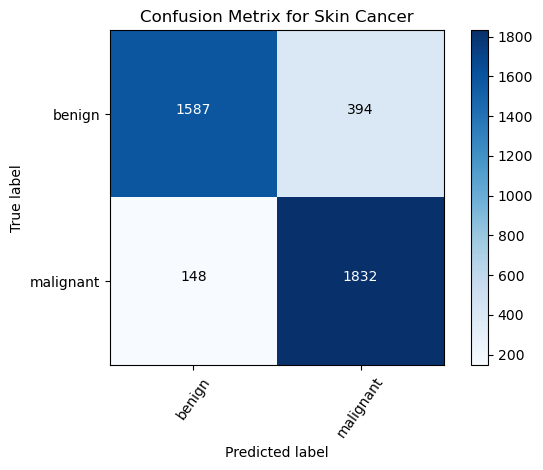

In [10]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[1571  410]
 [ 145 1835]]


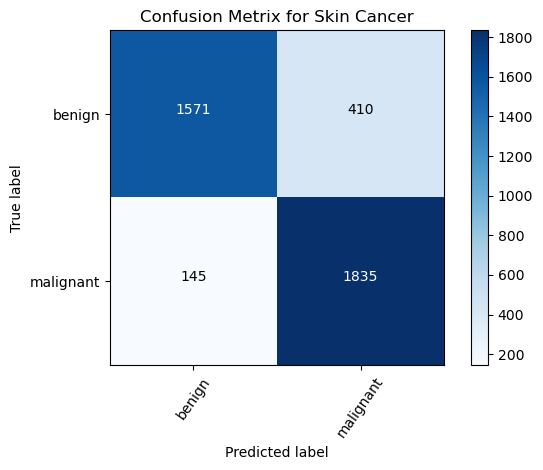

In [11]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

### Classification Report

In [12]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.92      0.79      0.85      1981\n           1       0.82      0.93      0.87      1980\n\n    accuracy                           0.86      3961\n   macro avg       0.87      0.86      0.86      3961\nweighted avg       0.87      0.86      0.86      3961\n'

### ROC and AUC

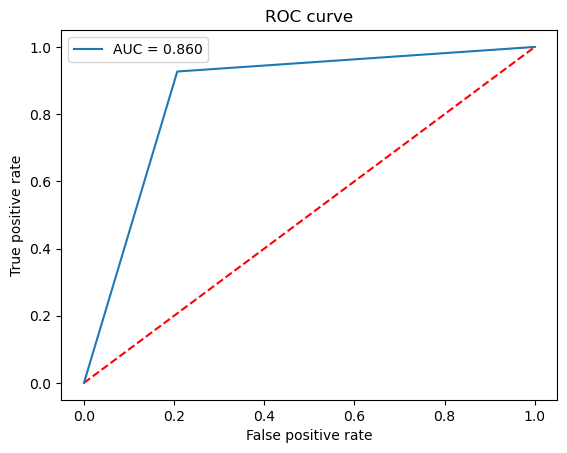

In [13]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()

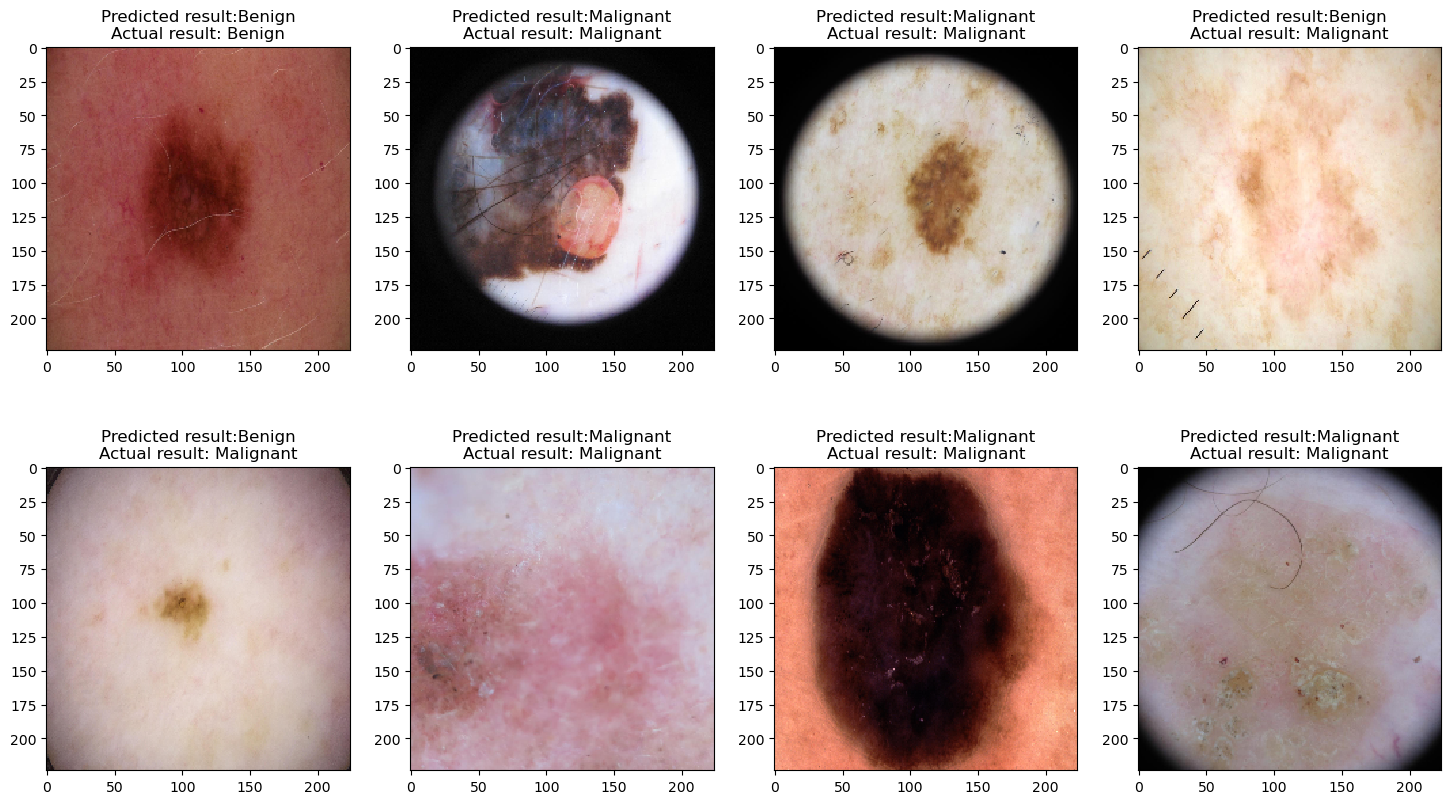

In [14]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    # if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
    #     prop_class.append(i)
    prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()